# Red Wine

This datasets is related to red variants of the Portuguese "Vinho Verde" wine.

&nbsp;

**LOL**

What makes good wine?

&nbsp;

**Table of Contents**

-Data Loading

-EDA

-ML

-Conclusion

&nbsp;

&nbsp;


---

## Data Loading

Imports and data loading

### Installation and Imports

In [34]:
import sys
import os
sys.path.append("utilities")

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn import metrics
import seaborn as sns
import pandas as pd
from scipy.stats import skew
from sklearn.inspection import permutation_importance
import shap

from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from scipy.stats import ks_2samp
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import utilities as utl

import numpy as np

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')



data_path = '/Users/mimi/Desktop/PYTHON/TURING/HOME/DA/SPRINT_3/data/winequality-red.csv'
df = pd.read_csv(data_path)
print(df[df.duplicated()==True].shape[0])
df.drop_duplicates(inplace=True)
print(df.shape)
print(df.isna().any().sum())



240
(1359, 12)
0


In [3]:
%load_ext autoreload

%autoreload 2

### Data Loading

Now that everything is installed and imported, let's get started by loading the data into a DataFrame

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.00,8.31,1.74,4.60,7.10,7.90,9.20,15.90
volatile acidity,1359.00,0.53,0.18,0.12,0.39,0.52,0.64,1.58
citric acid,1359.00,0.27,0.20,0.00,0.09,0.26,0.43,1.00
residual sugar,1359.00,2.52,1.35,0.90,1.90,2.20,2.60,15.50
chlorides,1359.00,0.09,0.05,0.01,0.07,0.08,0.09,0.61
free sulfur dioxide,1359.00,15.89,10.45,1.00,7.00,14.00,21.00,72.00
total sulfur dioxide,1359.00,46.83,33.41,6.00,22.00,38.00,63.00,289.00
density,1359.00,1.00,0.00,0.99,1.00,1.00,1.00,1.00
pH,1359.00,3.31,0.16,2.74,3.21,3.31,3.40,4.01
sulphates,1359.00,0.66,0.17,0.33,0.55,0.62,0.73,2.00


After looking at mean, min, and max, i suspect skewness all over the place. Lets take a look.

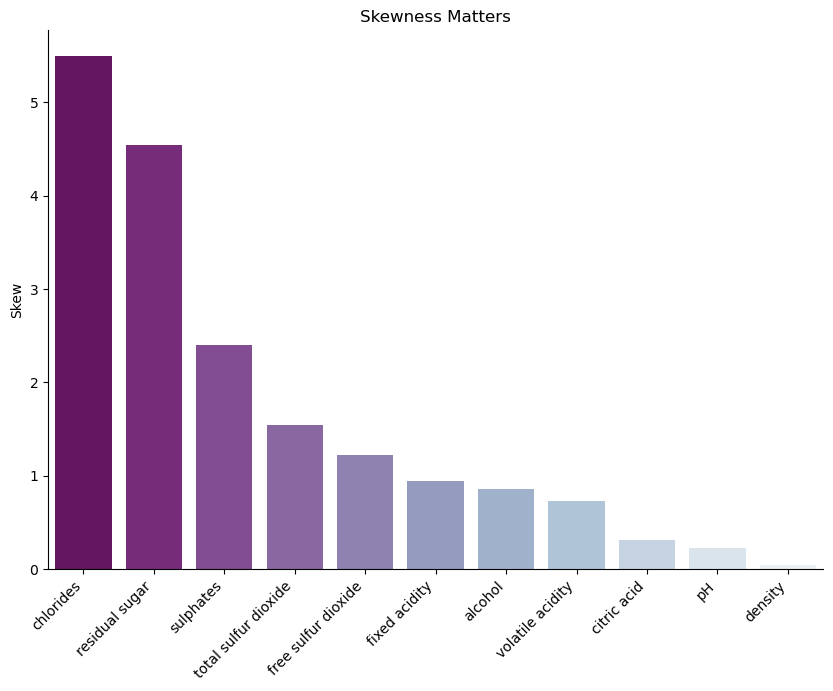

In [6]:
skewed_features = df.iloc[:, :-1].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skewed_features})   

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_title("Skewness Matters")

sns.barplot(x=skewness.index, y=skewness['Skew'], palette="BuPu_r")
plt.xticks(rotation=45, ha='right')  
sns.despine()
plt.show()

Lets see the effects of a log transformation

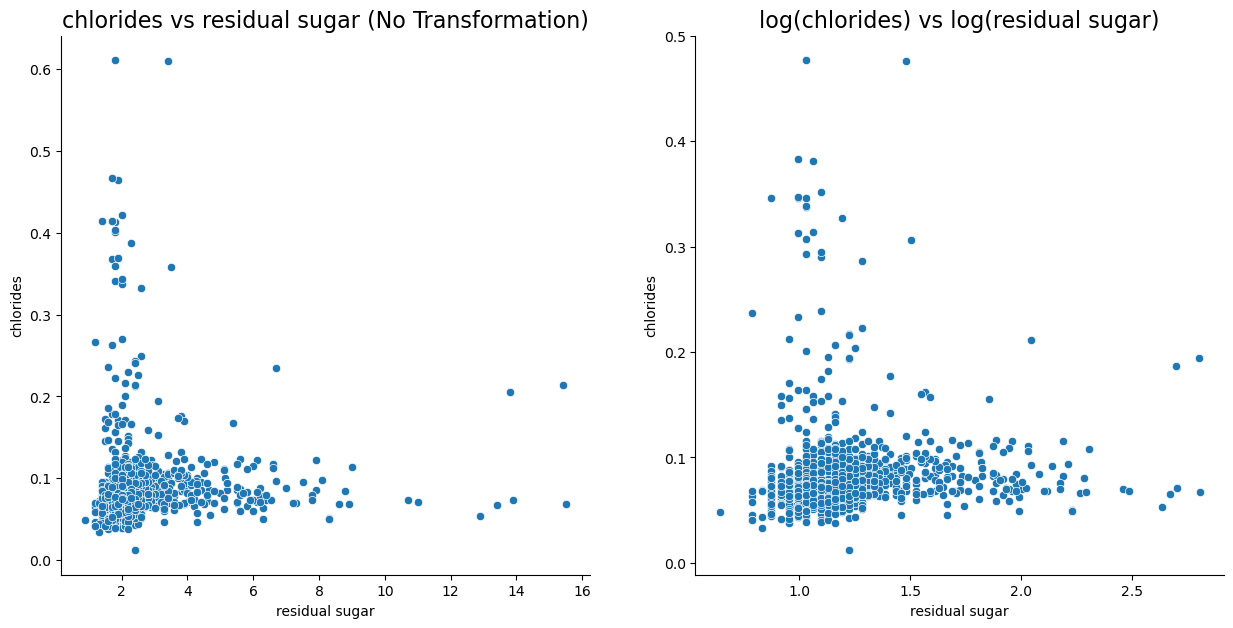

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)) 

# Scatter plot without transformation
sns.scatterplot(y=df['chlorides'], x=df['residual sugar'], palette="BuPu_r", ax=ax1) 
ax1.set_title("chlorides vs residual sugar (No Transformation)", fontsize=16)

# Scatter plot with log transformation
sns.scatterplot(y=df_log['chlorides'], x=df_log['residual sugar'], palette="BuPu_r", ax=ax2) 
ax2.set_title("log(chlorides) vs log(residual sugar)", fontsize=16)

sns.despine()
plt.show()

We see plenty of outliers still, however I will leave them as is for this project

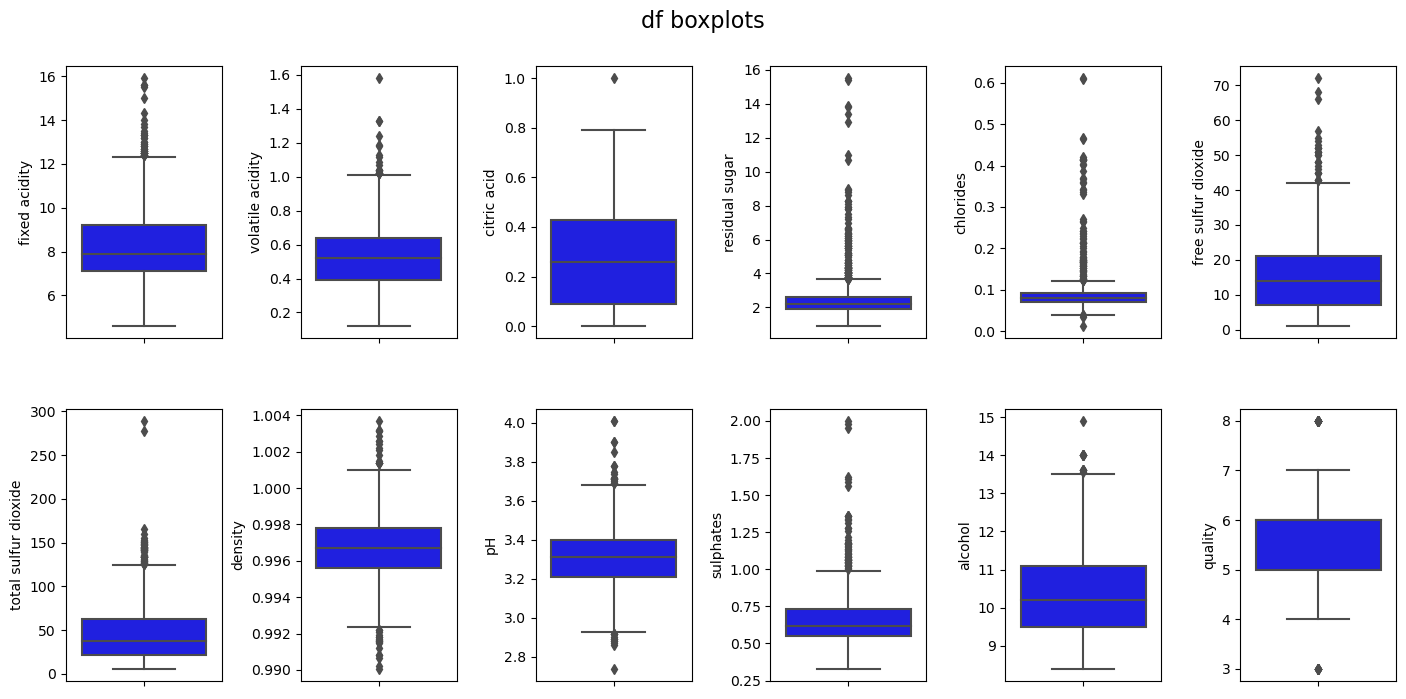

In [8]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14, 7))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.boxplot(y=col, data=df, color='b', ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
fig.suptitle("df boxplots", fontsize=16)
plt.show()

just as suspected, plenty of outliers.

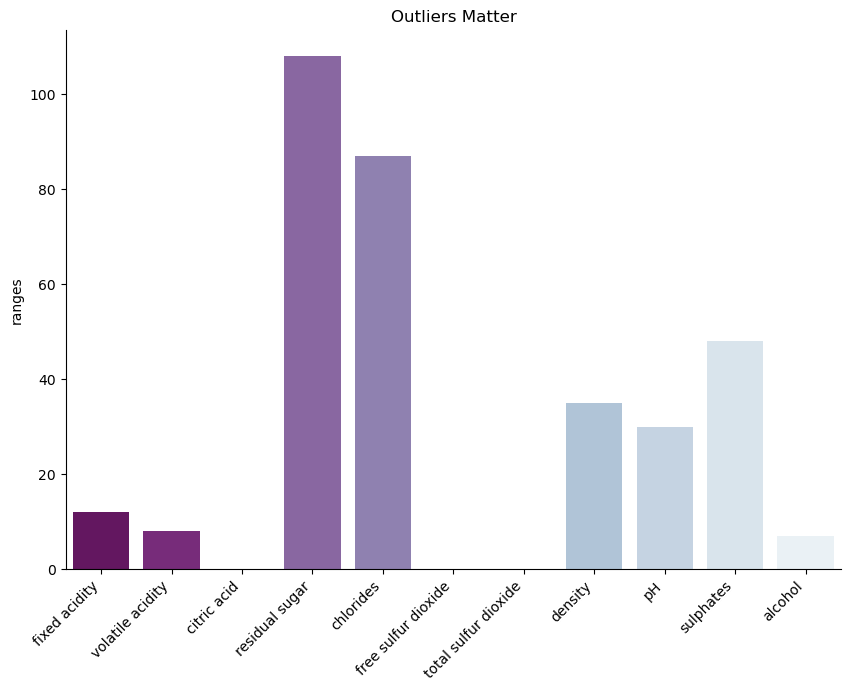

In [9]:
numeric_df = df_log.iloc[:, :-1]
Q1 = df_log.quantile(0.25)
Q3 = df_log.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
 
numeric_df[(numeric_df < lower) | (numeric_df > upper)].count()
outliers = pd.DataFrame({'ranges' :numeric_df[(numeric_df < lower) | (numeric_df > upper)].count()})   

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_title("Outliers Matter")

sns.barplot(x=outliers.index, y=outliers['ranges'], palette="BuPu_r")
plt.xticks(rotation=45, ha='right')  
sns.despine()
plt.show()

Lets look at our target variables

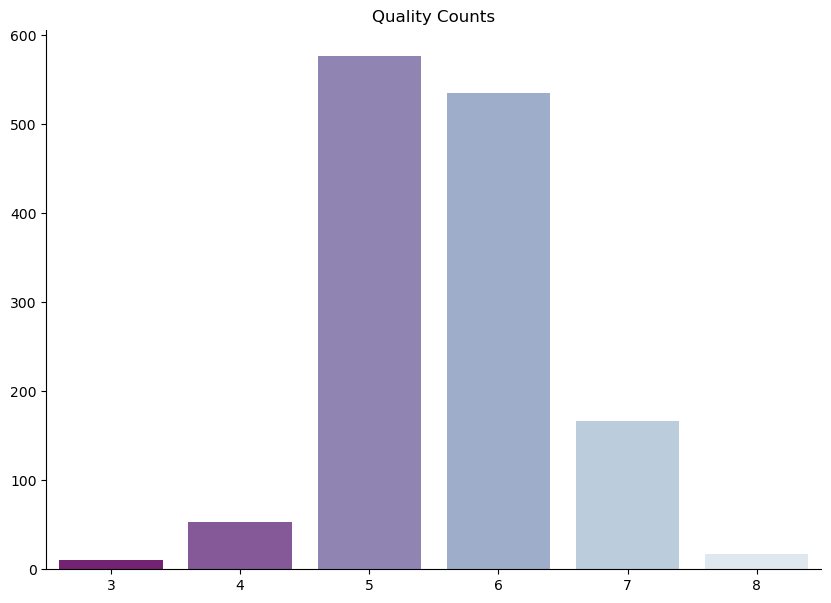

In [10]:
quality = df['quality'].value_counts().reset_index()
color = sns.color_palette("BuPu_r")

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_title("Quality Counts")

sns.barplot(x=quality['index'].values,
            y=quality['quality'].values, palette="BuPu_r" )
sns.despine()

Not ideal.

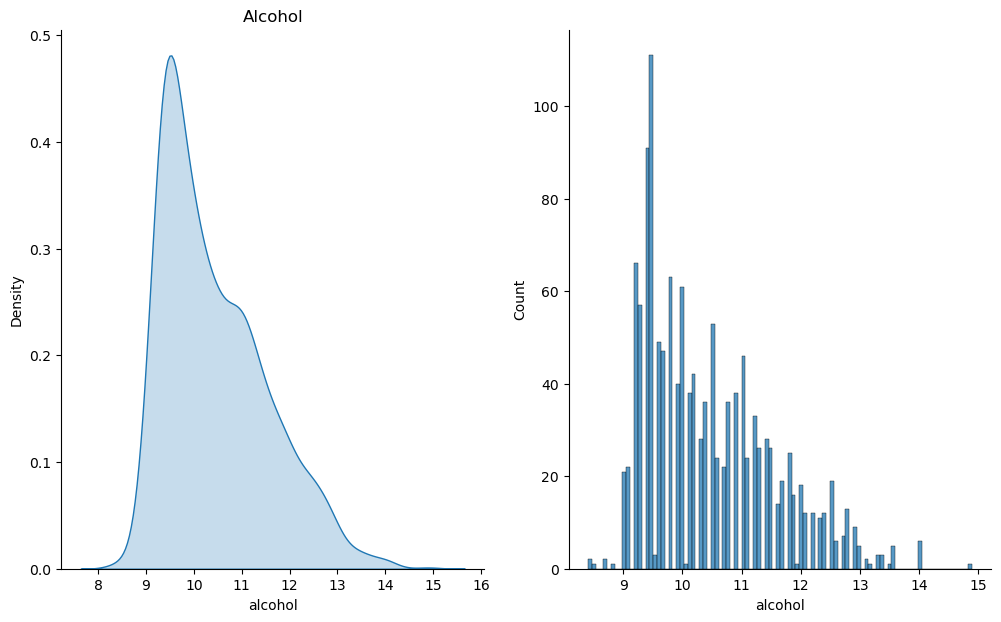

In [11]:
fig, ax = plt.subplots(1,2, figsize =(12, 7))

sns.kdeplot(x='alcohol', data=df, warn_singular=False, fill=True, ax=ax[0])
ax[0].set_title("Alcohol")


sns.histplot(df['alcohol'], bins=100, ax=ax[1])

sns.despine()
plt.show()

could be worse?

This concludes our EDA. 

&nbsp;

### Inference



On this episode, we will test whethere alcohol means of wine quality==5 is greater than the population (wine_df)!! <br>
<br>
Null Hypothesis - theres no difference between alcohol.mean() levels of wine['quality]==5 and the population['alcohol'].mean()<br>
<br>
Alternative Hypothesis theres a difference between alcohol.mean() levels of wine['quality]==5 and the population['alcohol'].mean()<br>
<br>
Test= One-Sample-Z-Test<br>
<br>
Alpha= 0.01<br>
<br>

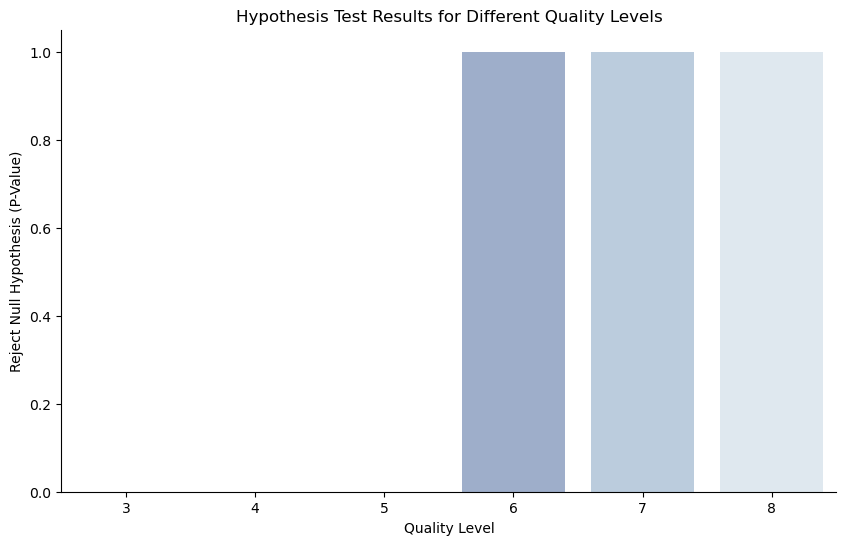

,Quality,Z-Score,Critical Z-Score,Reject Null (Critical Z-Score),P-Value,Reject Null (P-Value)
0,5,-12.070820,2.326348,False,1.0000,False
1,6,4.842978,2.326348,True,0.0000,True
2,7,12.645022,2.326348,True,0.0000,True
3,4,-1.125059,2.326348,False,0.8697,False
4,8,6.578692,2.326348,True,0.0000,True
5,3,-1.394928,2.326348,False,0.9185,False


In [17]:
sample_mean = df[df['quality'] == 5]['alcohol'].mean()
population_mean = df['alcohol'].mean()
population_std = df['alcohol'].std()
sample_size = len(df[df['quality'] == 5]['alcohol'])
alpha = 0.01


utl.hypothesis_test_all_qualities(df)

In conclusion, the alcohol distributions from each quality differ from the alcohol population. This menas that if we were to resample wines, we wouls see different results every time.

&nbsp;

### Data Normalization

We should normailize data before training. We also group wine qualities into good and bad wines, use stratified sampling to reduce biasness.


In [20]:
small_constant = 1e-10
df_log = np.log1p(df.iloc[:, :-1] + small_constant)
df_log['quality'] = df['quality']

df['Y'] = [ 1 if x >= 7 else 0 for x in df['quality']]
X = df_log.drop(['quality'], axis=1)
Y = df['Y']

n_splits = 5  
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


for train_index, test_index in stratified_kfold.split(X, Y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = df["Y"].iloc[train_index], df["Y"].iloc[test_index]

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1088, 11) (1088,)
(271, 11) (271,)


### Logistic Regression


In [21]:

logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(x_train, y_train)
y_pred = logisticRegr.predict(x_test)
y_train_pred = logisticRegr.predict(x_train)
y_test_pred = logisticRegr.predict(x_test)

print("Accuracy Score of Model on Training Data is =>",round(accuracy_score(y_train,y_train_pred)*100,2),"%")
print("Accuracy Score of Model on Testing Data  is =>",round(accuracy_score(y_test,y_test_pred)*100,2),"%")


Accuracy Score of Model on Training Data is => 87.22 %
Accuracy Score of Model on Testing Data  is => 87.08 %


Since both results are the same, this means we avoided overfitting.

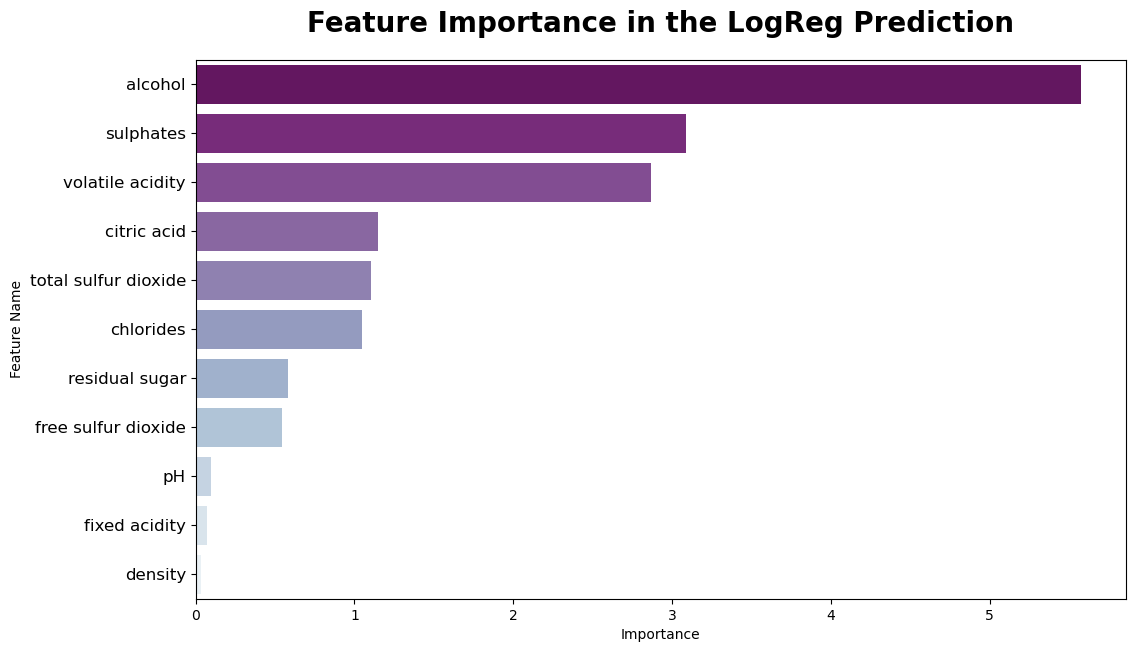

In [22]:
coefficients = logisticRegr.coef_[0]

imp_df = pd.DataFrame({"Feature Name":x_train.columns,
                       "Importance":np.abs(coefficients)})
features = imp_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importance", y="Feature Name", data=features, palette="BuPu_r")
plt.title("Feature Importance in the LogReg Prediction", fontweight="black", size=20, pad=20)
plt.yticks(size=12)
plt.show()

Here we have a breakdown of what features are important for "good' vs "bad" wine. This could help producers make their wine "better".

Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

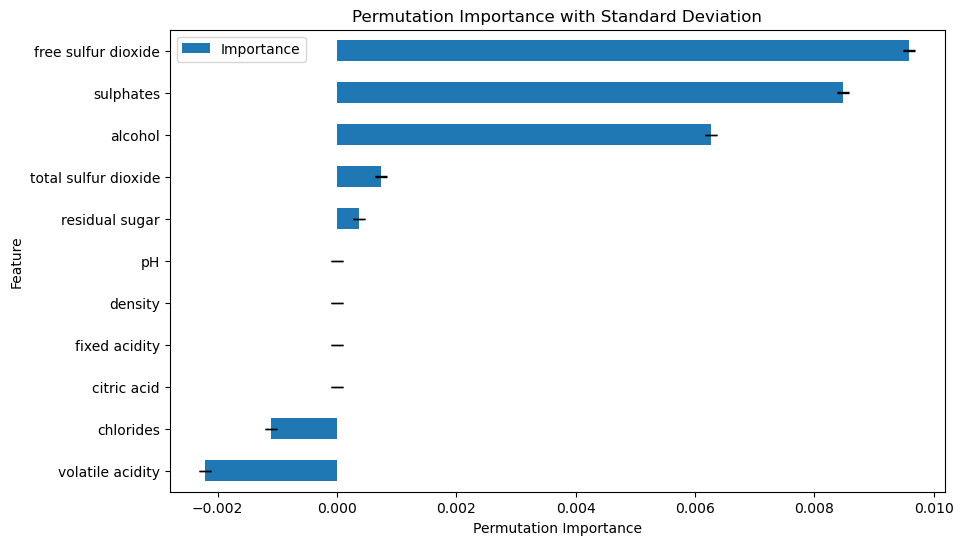

In [23]:

result = permutation_importance(logisticRegr, x_test, y_test, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')

this also tells us that chlorides and volatile acidity decrease model performance. If I had time to improve model performance, i would start here.

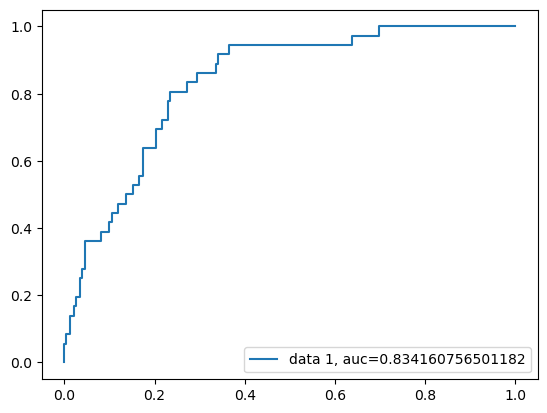

In [25]:
y_pred_proba = logisticRegr.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

the closer to 1, the better, so our model is okidoki.

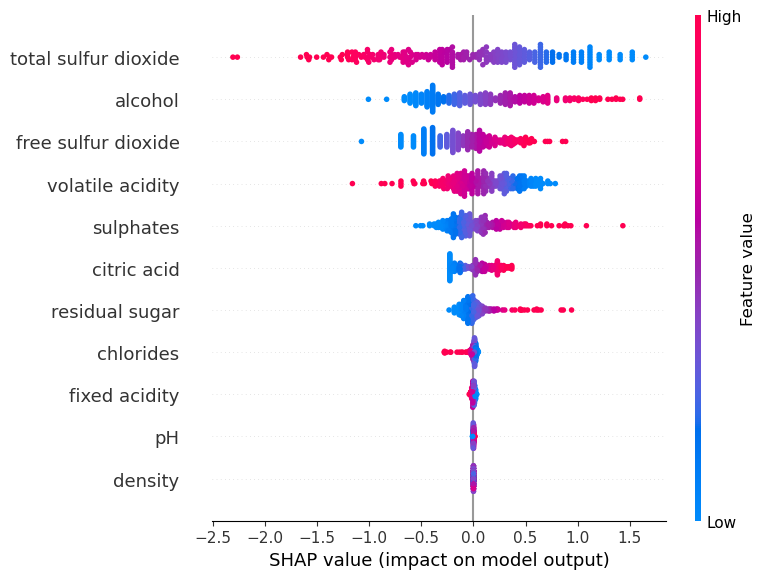

In [26]:

explainer = shap.Explainer(logisticRegr, x_train)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)



### Linear Regression


As an extra, since I used stratified kfolds in logreg, i looked up how to do so with Linreg, and found a solution!

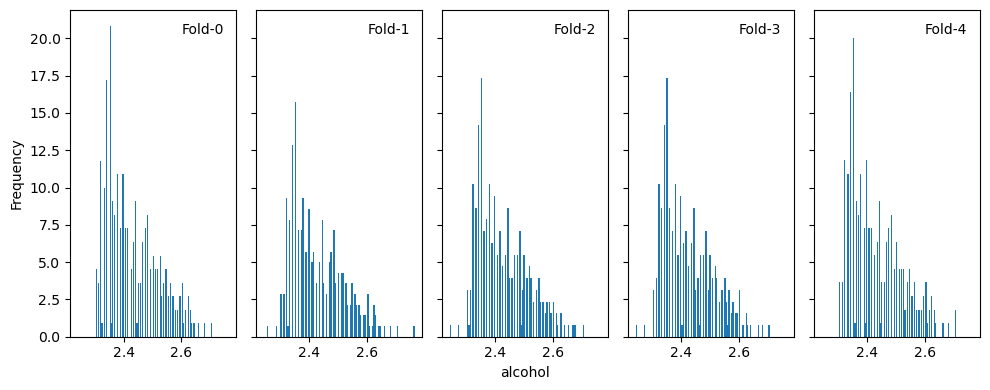

In [38]:
df_linreg = utl.create_folds(df_log, n_s=5, n_grp=1000)

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,4))
for i, ax in enumerate(axs):
    ax.hist(df_linreg[df_linreg.Fold == i]['alcohol'], bins=100, density=True, label=f'Fold-{i}')
    if i == 0:
        ax.set_ylabel('Frequency')
    if i == 2:
        ax.set_xlabel("alcohol")
    ax.legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

To verify my results, we use : Kolmogorov-Smirnov Test

In [39]:
for fold in np.sort(df_linreg.Fold.unique()):
    if fold == 0:
        continue  # Skip the comparison with itself
    print(f'Fold 0 vs {fold}:', ks_2samp(df_linreg.loc[df_linreg.Fold==0, 'alcohol'], df_linreg.loc[df_linreg.Fold==fold, 'alcohol']))

Fold 0 vs 1: KstestResult(statistic=0.011029411764705883, pvalue=1.0, statistic_location=2.517696472619056, statistic_sign=-1)
Fold 0 vs 2: KstestResult(statistic=0.011029411764705883, pvalue=1.0, statistic_location=2.3608540011274552, statistic_sign=1)
Fold 0 vs 3: KstestResult(statistic=0.01838235294117647, pvalue=0.9999999999836938, statistic_location=2.4680995314800938, statistic_sign=-1)
Fold 0 vs 4: KstestResult(statistic=0.010039070978945084, pvalue=1.0, statistic_location=2.3513752571730016, statistic_sign=1)


With a high p-value and a "low" statistic score, we failto reject the null hypothesis that the folds are different from the population

In [42]:
X = df_linreg.drop(['alcohol','grp'], axis=1)
Y = df_linreg['alcohol']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=X['Fold'])

columns_to_drop = ['Fold']
for df in [x_train, x_test, y_train, y_test]:
    df.drop(columns=columns_to_drop, inplace=True)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1019, 11)
(1019,)
(340, 11)
(340,)


In [44]:
ols = linear_model.LinearRegression()
ols.fit(x_train, y_train)
y_train_pred = ols.predict(x_train)
y_test_pred = ols.predict(x_test)

# Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# R-squared
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Mean Squared Error on Training Data:", mse_train)
print("Mean Squared Error on Testing Data:", mse_test)
print("R-squared on Training Data:", r2_train)
print("R-squared on Testing Data:", r2_test)

Mean Squared Error on Training Data: 0.0024293136938155937
Mean Squared Error on Testing Data: 0.0024212633428571176
R-squared on Training Data: 0.7142145044941058
R-squared on Testing Data: 0.7012490484775491


Looks like we did it again, we avoided overfitting.

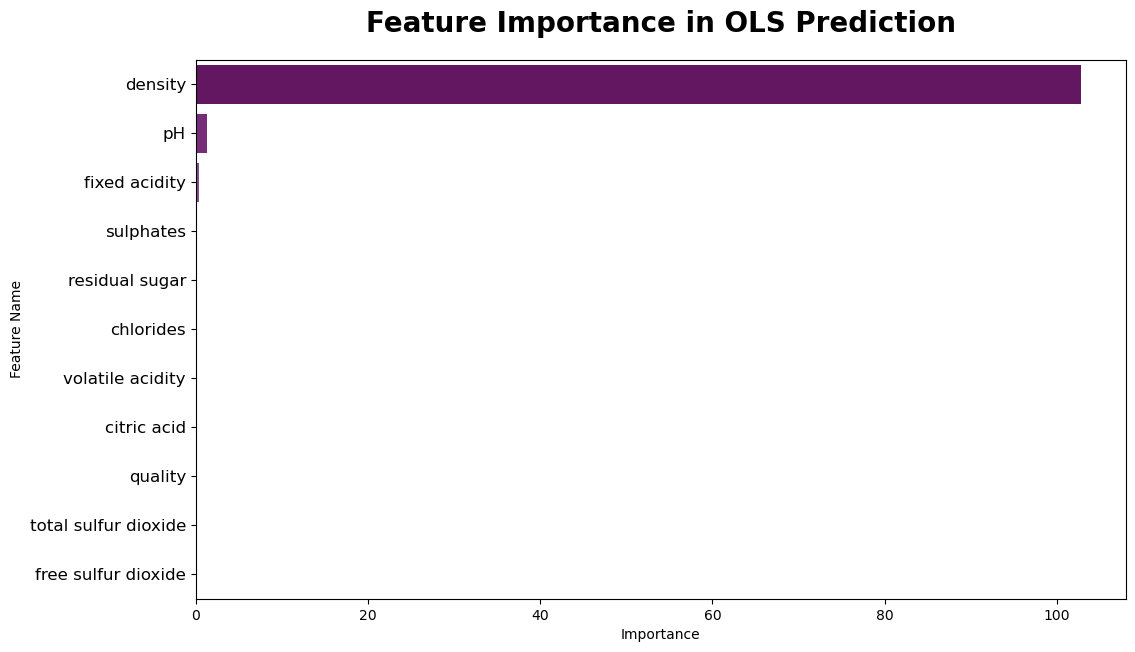

In [45]:
coefficients = ols.coef_

# Create a DataFrame to display feature names and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature Name': x_train.columns,  # Assuming x_train is your feature matrix
    'Importance': np.abs(coefficients)
})

# Sort the DataFrame by the absolute values of coefficients to highlight important features
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature Name', data=feature_importance, palette='BuPu_r')
plt.title('Feature Importance in OLS Prediction', fontweight='black', size=20, pad=20)
plt.yticks(size=12)
plt.show()


Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

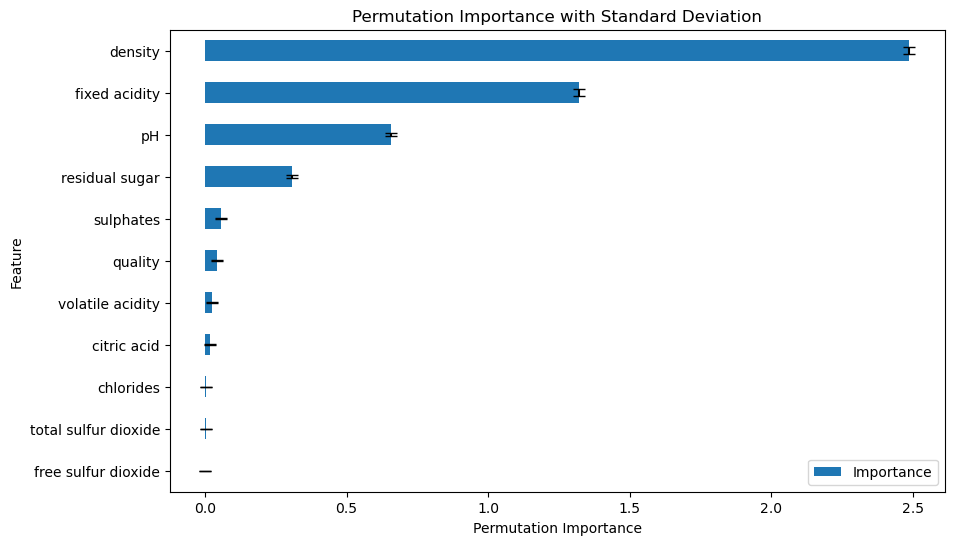

In [57]:

result = permutation_importance(ols, x_test, y_test, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': df_linreg[x_test.columns].columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')

Here we have some intertesting results as to what is associated with alcohol content

&nbsp;

&nbsp;

---

## Summary

These models would not do well in the "wild" and should not be considered effective, as a sample of alcohol from any quality comes from a different distribution than alcohol population. 

Also, the features mostly associated with quality to be used for future production purposes

&nbsp;

&nbsp;

---

## Improvements

Feature Engineering and outliers